##Lab 5 - Style Transfer

## Initialization

In [4]:
!pip3 install torchvision

In [0]:
import io 
import gc
import copy
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from google.colab import files
from torchvision import transforms, utils, datasets, models
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

In [6]:
load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])
 
print('Upload Content Image')
file_dict = files.upload()
content_image = Image.open(io.BytesIO(file_dict[next(iter(file_dict))]))
content_image = load_and_normalize(np.array(content_image)).unsqueeze(0)
 
print('\nUpload Style Image')
file_dict = files.upload()
style_image = Image.open(io.BytesIO(file_dict[next(iter(file_dict))]))
style_image = load_and_normalize(np.array(style_image)).unsqueeze(0)

Upload Content Image


Saving IMG_20181116_191621.jpg to IMG_20181116_191621.jpg

Upload Style Image


Saving pablo-picasso-femme-assise-robe-bleue.jpg to pablo-picasso-femme-assise-robe-bleue.jpg


## Modules

In [0]:
# VGG Network
class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):    
          m.inplace = False           
          
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(x)  
    return self.intermediates

In [0]:
# Content Loss Module
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()
    
  def forward(self, input):
    return F.mse_loss(input, self.target)
  

# Style Loss Module
class StyleLoss(nn.Module):
  def __init__(self, target):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target).detach()
  
  def forward(self,input):
    G = gram_matrix(input)
    return F.mse_loss(G, self.target)
  
def gram_matrix(input):
  a, b, c, d = input.size()
  features = input.view(a * b, c * d)
  G = torch.mm(features, features.t())
  return G.div(a * b * c * d)

## Main

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:11<00:00, 50035770.89it/s]


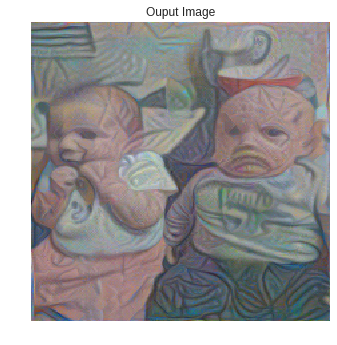

In [9]:
def scope():
  try:
    # Parameters
    STEPS = 800
    S_LAYERS = [0,5,10,19,24,]
    C_LAYERS = [19]
    S_WEIGHT = 1000000
    C_WEIGHT = 1
    
    # Initialize
    vgg_c = VGGIntermediate(requested=C_LAYERS).cuda()
    vgg_s = VGGIntermediate(requested=S_LAYERS).cuda()
    vgg_i = VGGIntermediate(requested=S_LAYERS + C_LAYERS).cuda()
    content_layers = vgg_c(content_image.cuda())
    style_layers = vgg_s(style_image.cuda())
    image = content_image.cuda()
    optimizer = optim.Adam([image.requires_grad_()], lr=0.1)
    
    gc.collect()
    
    # Begin Optimization!
    loop = tqdm(total=STEPS, position=0, leave=False)
    for i in range(STEPS):
      optimizer.zero_grad()
      input_layers = vgg_i(image) # Run image through vgg

      style_loss = 0
      for layer in S_LAYERS: # Get Style loss at specified layers
        objective_s = StyleLoss(style_layers[layer])
        style_loss += objective_s(input_layers[layer])
      content_loss = 0
      for layer in C_LAYERS: # Get content loss at specified layers
        objective_c = ContentLoss(content_layers[layer])
        content_loss += objective_c(input_layers[layer])
        
      content_loss *= C_WEIGHT
      style_loss *= S_WEIGHT
      
      loss = content_loss + style_loss
      loss.backward()
      optimizer.step() # Take step
      
      loop.set_description('content loss:{:.4f}, style loss:{:.4f}'
                           .format(content_loss.item(), style_loss.item()))
      loop.update(1)
      
    loop.close() 
    
    # Print New Image
    image = image - torch.min(image)
    image = image / torch.max(image)
    img = image.squeeze().permute(1, 2, 0)
    img = img.detach()
    plt.axis("off")
    plt.title("Ouput Image")
    plt.imshow(img)
    plt.show()   
    
  except:
    __ITB__()
  
scope()